# Brain2brain Basic - LSTM

In [1]:
# Autoreload
%load_ext autoreload
%autoreload 2

In [2]:
# Imports
import sys
import time
import string
import json
import os
# General
import numpy as np
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from contextlib import redirect_stdout
from pathlib import Path
# brain2brain
import sys
sys.path.append('../../')
from brain2brain import utils
from brain2brain import generators
# TCN
from brain2brain.tcn import TCN
from brain2brain.tcn import compiled_tcn
# TF
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Flatten, GRU, Lambda, TimeDistributed

In [4]:
raw_file_paths_676 = utils.get_file_paths_from_root(patient_number=676, sort=True)

In [9]:
data = np.load(raw_file_paths_676[0])
data.shape

(1623762, 114)

In [6]:
mean, std = utils.get_mean_std(raw_file_paths_676)

Calculating mean per electrode
Calculating std per electrode
Std per electrode is [71.13064293 70.84265295 69.40774496 64.33098207 64.16377832 75.34519979
 63.29284364 77.10892117 72.81626813 64.62068213 65.22269059 62.14632494
 60.93759175 63.46678688 65.64195109 72.32317576 68.18851095 66.38626671
 60.07914386 61.48605238 65.7188924  64.49431583 70.44651055 79.79647673
 64.535309   64.70682381 59.75301302 61.07904396 64.1099533  68.21511705
 68.97148854 67.06749177 79.24131611 72.0475781  62.34674237 73.54098663
 71.17913574 68.91193581 69.06073784 66.62026785 80.64623515 65.97039115
 65.54457069 66.25036309 71.76654797 73.82055264 66.48882973 75.66503325
 79.76890838 67.27098858 65.89716884 67.0019205  61.56665798 68.3622989
 66.61012402 79.63358968 85.02525622 66.70177034 65.67046824 70.33367655
 68.2686621  67.07376913 67.6632362  66.78017962 96.71299928 91.54459015
 87.12959038 68.86423935 74.1839993  88.43551036 80.32949601 69.18538599
 74.67441157 65.43992437 66.34349318 67.158

In [10]:
l = data - mean


(1623762, 114)

In [18]:
new_data = data[:(data.shape[0] // 25) * 25]
print(new_data.shape)
# new_data = new_data.reshape(-1, avg_timestep_count, data.shape[1]).mean(axis=1)

(1623750, 114)


In [20]:
new_data = new_data.reshape(-1, 25, 114)
print(new_data.shape)

(64950, 25, 114)


In [3]:
file_path_bin_norm_676 = "/home/tmarcu/brain2brain/brain2brain/train_676_bin_norm_files_projects.txt"
file_path_norm_676 = "/home/tmarcu/brain2brain/brain2brain/train_676_norm_files_projects.txt"

In [4]:
all_bin_norm_676 = utils.get_file_paths(file_path_bin_norm_676)
all_norm_676 = utils.get_file_paths(file_path_norm_676)

In [20]:
m = np.array([[0,1,2],[3,4,5], [6, 7, 8], [9, 10, 11]])
m - 1

array([[-1,  0,  1],
       [ 2,  3,  4],
       [ 5,  6,  7],
       [ 8,  9, 10]])

In [31]:
m

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11]])

In [30]:
np.sum(abs(m - 1) ** 2, axis = 0)

array([ 94, 126, 166])

In [85]:
utils.get_std(all_norm_676)

Calculating mean per electrode
Calculating std per electrode
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(36853, 114)
[36853. 36853. 36853. 36853. 36853. 36853. 36853. 36853. 36853. 36853.
 36853. 36853. 36853. 36853. 36853. 36853. 36853. 36853. 36853. 36853.
 36853. 36853. 36853. 36853. 36853. 36853. 36853. 36853. 36853. 36853.
 36853. 36853. 36853. 36853. 36853. 36853. 36853. 36853. 36853. 36853.
 36853. 36853. 36853. 36853. 36853. 36853. 36853. 36853. 36853. 36853.
 36853. 36853. 36853. 36853. 36853. 36853. 36853. 36853. 36853. 36853.
 36853. 36853. 36853. 36853. 36853. 36853. 36853. 36853. 36853. 36853.
 36853. 36853. 36853. 36853. 36853. 36853. 36853. 36853. 36853. 36853.
 36853. 36

(array([ 1.23082557e-17,  1.05688824e-17,  7.44802132e-18,  3.06379963e-17,
         1.42603580e-17,  2.50369641e-17,  1.35095494e-17, -1.00658406e-17,
        -5.92638256e-18,  3.82624577e-17,  3.95676133e-18, -3.74803654e-17,
        -5.00038528e-18, -6.83761393e-17, -7.59067496e-17,  2.08975061e-17,
         4.10442035e-19, -2.04945721e-17,  2.08849926e-17,  9.11481642e-18,
        -5.17156964e-17,  1.20229484e-17, -7.13768710e-18,  9.87563580e-18,
         2.36241926e-17,  7.91051942e-17,  4.12631894e-17,  4.43352479e-17,
        -4.47206630e-17, -1.63917159e-17,  5.14028595e-17,  2.60180207e-17,
         2.94316972e-18,  1.56105622e-17,  2.35003092e-17,  3.38214248e-17,
         2.26794251e-17, -5.76996410e-17, -6.74226124e-18, -5.69970093e-17,
         5.37253608e-17, -3.13612753e-17,  3.94424785e-17, -1.69282313e-17,
         1.95860937e-17,  6.12409549e-18, -3.86678943e-17, -7.51309140e-18,
         3.74002791e-17, -5.28143797e-17,  1.28638540e-18,  2.50156912e-17,
         5.9

In [35]:
# Split the files in train and validation
train_bin_norm_676, val_bin_norm_676 = utils.split_file_paths(file_paths=all_bin_norm_676, split_ratio = 0.8)
train_norm_676, val_norm_676 = utils.split_file_paths(file_paths=all_norm_676, split_ratio = 0.8)

In [17]:
print("Bin_Norm Shape Train:")
for path in train_bin_norm_676:
    print(f"Path: {path}. Rows: {utils.get_file_shape(path, print_flag=False)[0]}")
print("Bin_Norm Shape Val:")
for path in val_bin_norm_676:
    print(f"Path: {path}. Rows: {utils.get_file_shape(path, print_flag=False)[0]}")

Bin_Norm Shape Train:
Path: /projects/HASSON/247/data/binned_conversations/676_bin_norm/binned_norm_NY676_618_Part8_conversation1/binned_norm_NY676_618_Part8_conversation1.npy. Rows: 1987
Path: /projects/HASSON/247/data/binned_conversations/676_bin_norm/binned_norm_NY676_618_Part6_conversation1/binned_norm_NY676_618_Part6_conversation1.npy. Rows: 40965
Path: /projects/HASSON/247/data/binned_conversations/676_bin_norm/binned_norm_NY676_616_Part1_conversation3/binned_norm_NY676_616_Part1_conversation3.npy. Rows: 1857
Path: /projects/HASSON/247/data/binned_conversations/676_bin_norm/binned_norm_NY676_620_Part7_conversation1/binned_norm_NY676_620_Part7_conversation1.npy. Rows: 36037
Path: /projects/HASSON/247/data/binned_conversations/676_bin_norm/binned_norm_NY676_618_Part4_conversation1/binned_norm_NY676_618_Part4_conversation1.npy. Rows: 8010
Path: /projects/HASSON/247/data/binned_conversations/676_bin_norm/binned_norm_NY676_621_Part2-one_conversation1/binned_norm_NY676_621_Part2-one_co

In [15]:
print("Norm Shape Train:")
for path in train_norm_676:
    utils.get_file_shape(path)
print("Norm Shape Val:")
for path in val_norm_676:
    utils.get_file_shape(path)

Norm Shape Train:
(36853, 114)
(30031, 114)
(1288999, 114)
(409822, 114)
(1073405, 114)
(1024138, 114)
(635016, 114)
(11281, 114)
(1472079, 114)
(751292, 114)
(1836899, 114)
(2004633, 114)
(160325, 114)
(30583, 114)
(49689, 114)
(327455, 114)
(209245, 114)
(2967538, 114)
(900928, 114)
(2734, 114)
(125438, 114)
(81209, 114)
(325938, 114)
(17630, 114)
(2984936, 114)
(157269, 114)
(415513, 114)
(16079, 114)
(282869, 114)
(646487, 114)
(388963, 114)
(2304251, 114)
(43859, 114)
(12256, 114)
(1298863, 114)
(3817151, 114)
(874145, 114)
(698567, 114)
(46425, 114)
(10352, 114)
(1623762, 114)
(597144, 114)
(11727, 114)
(200261, 114)
(135731, 114)
(532788, 114)
(437006, 114)
(2552413, 114)
(127243, 114)
(4096153, 114)
Norm Shape Val:
(3008310, 114)
(160956, 114)
(828971, 114)
(2279510, 114)
(666125, 114)
(1415249, 114)
(3281653, 114)
(21770, 114)
(437405, 114)
(1400263, 114)


# One-to-one LSTM (Bin Norm)

In [21]:
train_path_676_test = "/projects/HASSON/247/data/binned_conversations/676_bin_norm/binned_norm_NY676_619_Part2_conversation2/binned_norm_NY676_619_Part2_conversation2.npy"

In [22]:
# Load data
data = np.load(train_path_676_test)

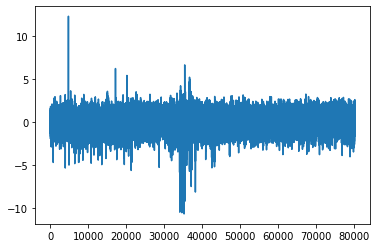

In [23]:
# Plot one electrode
signal = data[:,0]
plt.plot(range(len(signal)), signal)

In [ ]:
# Generator (see Deep Learning with Python pag. 211)
# data - the original array of floating-point data.
# lookback - How many timesteps back the input data should go.
# delay - How many timesteps in the future the target should be.
# min_index and max_index - Indices in the data arr that delimit which time steps to draw from. 
#     This is useful for splitting the data in training, validation, and test.
# shuffle - Whether to shuffle the samples or draw them in chronological order.
# batch_size - The number of samples per batch.
# step - The period, in timesteps, at which you sample data. 
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index == None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while True:
        if shuffle:
            rows = np.random.randint(min_index + lookback,
                                     max_index,
                                     size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                           lookback // step, 
                           data.shape[-1]))
        targets = np.zeros((len(rows), ))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j